## Strategy:

1. Data Loading & Quick Glance:
   Load the training data and have a quick glance at the first few rows to understand its structure.

2. Feature Engineering:
   Create new features based on domain knowledge.

3. Feature Selection:
   Compute a correlation matrix for the top 50 features with the target variable (SalePrice). Handle missing values in these features. Then, use Mutual Information (MI) to select features from this set.

4. Data Preprocessing:
   Handle missing values, one-hot encode categorical variables, and scale the features.

5. Model Training:
   Train models on two different sets of features: the top correlated features and the top MI features.

6. Model Evaluation:
   Use metrics like RMSE and r^2   to evaluate model performance on the training data (using cross-validation).

7. Visualization:
   Visualize relevant graphs as needed during each step.

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

## 1. Data Loading & Quick Glance:

In [2]:
#  load the training data
train_data = pd.read_csv('../data_details/train.csv')

# Drop the id column
train_data = train_data.drop(columns=['Id'])

# Display the first few rows of the dataset
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Feature Engineering:
We'll create new features based on domain knowledge:

- Total Area
- Total Square Feet of Property
- Age of House at Sale
- Total Bathrooms
- Total Porch Area
- Presence of Pool
- Remodeling Indicator
- Interaction feature between overall quality and living area

In [3]:

# Feature Engineering

# Total Area
train_data['TotalArea'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']

# Total Square Feet of Property (including garage)
train_data['TotalSFProperty'] = train_data['TotalArea'] + train_data['GarageArea']

# Age of House at Sale
train_data['AgeAtSale'] = train_data['YrSold'] - train_data['YearBuilt']

# Total Bathrooms (full and half)
train_data['TotalBathrooms'] = train_data['FullBath'] + 0.5*train_data['HalfBath'] + train_data['BsmtFullBath'] + 0.5*train_data['BsmtHalfBath']

# Total Porch Area
train_data['TotalPorchArea'] = train_data['OpenPorchSF'] + train_data['EnclosedPorch'] + train_data['3SsnPorch'] + train_data['ScreenPorch']

# Presence of Pool
train_data['HasPool'] = train_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# Remodeling Indicator
train_data['Remodeled'] = (train_data['YearRemodAdd'] != train_data['YearBuilt']).astype(int)

# Interaction feature between overall quality and living area
train_data['Quality_LivArea_Interaction'] = train_data['OverallQual'] * train_data['GrLivArea']

# Display the first few rows to ensure successful feature engineering
train_data[['TotalArea', 'TotalSFProperty', 'AgeAtSale', 'TotalBathrooms', 'TotalPorchArea', 'HasPool', 'Remodeled', 'Quality_LivArea_Interaction']].head()


train_data.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleCondition,SalePrice,TotalArea,TotalSFProperty,AgeAtSale,TotalBathrooms,TotalPorchArea,HasPool,Remodeled,Quality_LivArea_Interaction
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,Normal,208500,2566,3114,5,3.5,61,0,0,11970
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,Normal,181500,2524,2984,31,2.5,0,0,0,7572
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,Normal,223500,2706,3314,7,3.5,42,0,1,12502
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,Abnorml,140000,2473,3115,91,2.0,307,0,1,12019
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,Normal,250000,3343,4179,8,3.5,84,0,0,17584


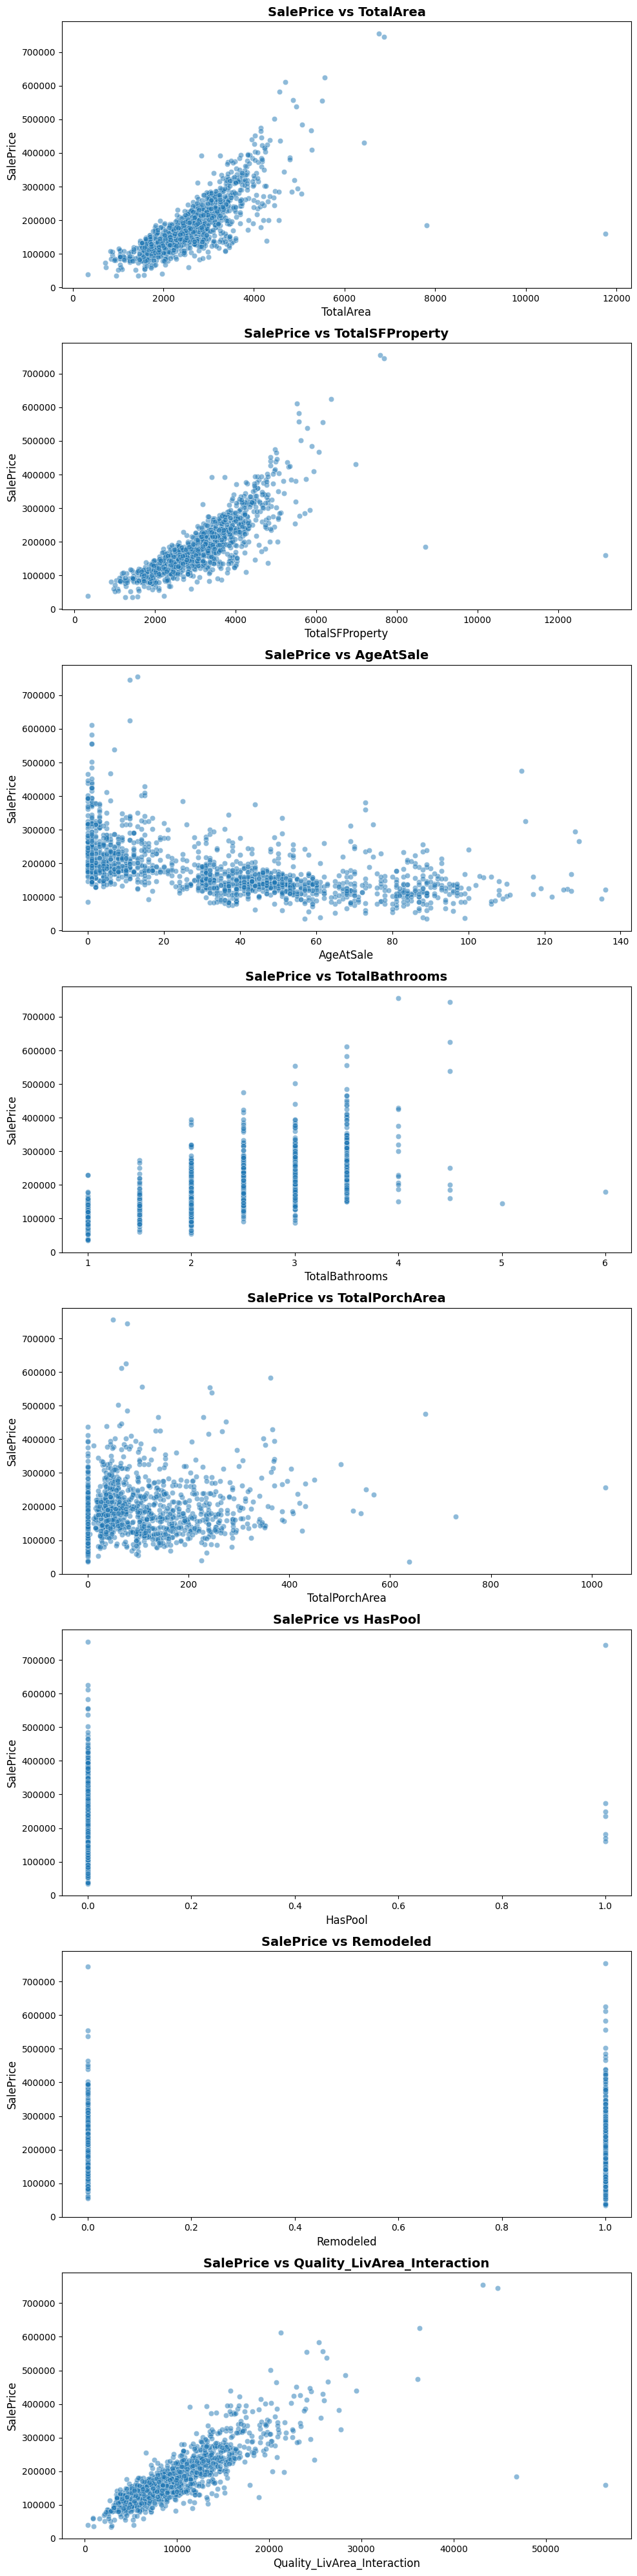

In [4]:

# Define a list of features to plot
features_to_plot = ['TotalArea', 'TotalSFProperty', 'AgeAtSale', 'TotalBathrooms', 'TotalPorchArea', 'HasPool', 'Remodeled', 'Quality_LivArea_Interaction']

# Create a figure and a grid of subplots
fig, axs = plt.subplots(len(features_to_plot), figsize=(10, 40))

# Iterate over the list of features
for i, feature in enumerate(features_to_plot):
    # Create a scatter plot for each feature
    sns.scatterplot(data=train_data, x=feature, y='SalePrice', alpha=0.5, ax=axs[i])
    
    # Set the title of the subplot
    axs[i].set_title(f'SalePrice vs {feature}', fontsize=14, fontweight='bold')
    
    # Set the x-label of the subplot
    axs[i].set_xlabel(feature, fontsize=12)
    
    # Set the y-label of the subplot
    axs[i].set_ylabel('SalePrice', fontsize=12)

# Adjust the layout for better visualization
plt.tight_layout()

# Display the plots

# We are doing this to visually inspect the relationship between the engineered features and the target variable (SalePrice).
# This will help us understand if the new features have a linear relationship with the target, which is a key assumption in linear regression models.
# It also helps us identify potential outliers that could affect model performance.
plt.show()



## 3. Feature Selection




I am using two different strategies for feature selection: one based on correlation and the other on Mutual Information (MI) scores. The correlation method was chosen following a discussion with Ege, while MI scores were selected because they can capture any type of relationship, including linear, nonlinear. 

 I initially considered using only MI scores to select features. 
 
 I plan to create several feature sets based on MI scores - such as the 'elbow' set, top 10 percent, 20 percent, 30 percent, 40 percent, and 50 percent - and compare the performance of models trained on these sets. This comparison will help identify the optimal number of features for our models.

I will also create a feature set based on correlation thresholds to compare its performance against the MI-based feature sets. By using multiple feature selection strategies, I aim to identify the most predictive and robust set of features for our house price prediction models.

### Feature selection based on Correlation

### Approach to Feature Selection Based on Correlation

Our approach to feature selection based on correlation involves the following steps:

1. Compute the correlation of each feature with the target variable (SalePrice).
2. Sort the features based on their correlation values in descending order. This gives us a list of features that are most strongly correlated with the target variable.
3. Visualize the feature distribution
4. Based on the correlation values, select a subset of features for our model trainings. 


In [6]:
# Calculate the correlation of each feature with the target variable
correlations = train_data.corr()['SalePrice'].sort_values(ascending=False)

# Display the correlation of each feature with the target variable 'SalePrice'
print(correlations)


SalePrice                      1.000000
Quality_LivArea_Interaction    0.832057
TotalSFProperty                0.809561
OverallQual                    0.790982
TotalArea                      0.782260
GrLivArea                      0.708624
GarageCars                     0.640409
TotalBathrooms                 0.631731
GarageArea                     0.623431
TotalBsmtSF                    0.613581
1stFlrSF                       0.605852
FullBath                       0.560664
TotRmsAbvGrd                   0.533723
YearBuilt                      0.522897
YearRemodAdd                   0.507101
GarageYrBlt                    0.486362
MasVnrArea                     0.477493
Fireplaces                     0.466929
BsmtFinSF1                     0.386420
LotFrontage                    0.351799
WoodDeckSF                     0.324413
2ndFlrSF                       0.319334
OpenPorchSF                    0.315856
HalfBath                       0.284108
LotArea                        0.263843


C:\Users\eseoghene\AppData\Local\Temp\ipykernel_14688\3595552036.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = train_data.corr()['SalePrice'].sort_values(ascending=False)


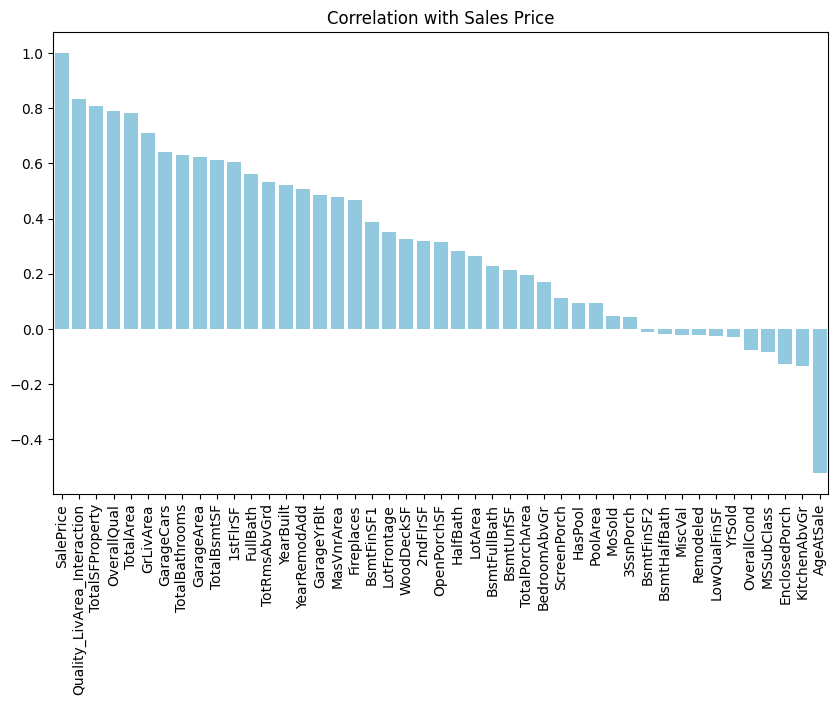

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, color='skyblue')
plt.title('Correlation with Sales Price')
plt.xticks(rotation=90)
plt.show()


I have decided to retain features such as OverallQual, GrLivArea, TotalBsmtSF, 1stFlrSF, FullBath etc., as they exhibit strong correlations above 0.5 with the target variable, SalePrice. 

Additionally, I am including features like WoodDeckSF, LotFrontage, BsmtFullBath etc., which have weaker but still decent correlations in the 0.3-0.5 range. I believe these features are predictive enough of SalePrice to be included in the model.

I am also considering features with moderate negative correlations, such as AgeAtSale, which has a correlation of -0.52. However, I am excluding features with very low correlations, specifically those less than 0.1 or close to zero, as they are unlikely to contribute significantly to the model's predictive power.


In [8]:
correlation_threshold = 0.3
correlation_features = correlations[(correlations > correlation_threshold) | (correlations < -correlation_threshold)]

# The selected features in this threshold are our correlation set
# We will use this as one set for models training and evaluation
correlation_set = pd.DataFrame(correlation_features.index, columns=['Features'])
correlation_set.index += 1

# Print the selected features as a dataframe with numbered index
print(correlation_set)


                       Features
1                     SalePrice
2   Quality_LivArea_Interaction
3               TotalSFProperty
4                   OverallQual
5                     TotalArea
6                     GrLivArea
7                    GarageCars
8                TotalBathrooms
9                    GarageArea
10                  TotalBsmtSF
11                     1stFlrSF
12                     FullBath
13                 TotRmsAbvGrd
14                    YearBuilt
15                 YearRemodAdd
16                  GarageYrBlt
17                   MasVnrArea
18                   Fireplaces
19                   BsmtFinSF1
20                  LotFrontage
21                   WoodDeckSF
22                     2ndFlrSF
23                  OpenPorchSF
24                    AgeAtSale


## Handling missing values

check for missing values in overall set and corr set to confirm and compare.


In [9]:
# Check for missing values in the overall set
missing_values_overall = train_data.isnull().sum()
print("Missing values in overall set:\n", missing_values_overall[missing_values_overall > 0])

print("\n")

# Check for missing values in the correlation set
missing_values_corr_set = train_data[correlation_set['Features']].isnull().sum()
print("Missing values in correlation set:\n", missing_values_corr_set[missing_values_corr_set > 0])


Missing values in overall set:
 LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


Missing values in correlation set:
 GarageYrBlt     81
MasVnrArea       8
LotFrontage    259
dtype: int64


While we appear to have a lot of missing values, we can see that many features in the dataset have missing values that are intentional and signify the absence of a certain feature in a house.  For instance, a NaN in PoolQC probably means there is no pool. We'll handle these by filling them with "None" or "Not Present" for categorical features and 0 for numerical ones.


So I decide to impute missing values in LotFrontage with the median LotFrontage of the neighborhood.

The feature Electrical has just one missing value, and so we can replace it with the mode of the column without introducing much bias.

In [10]:

# Features where NaN means the feature doesn't exist
features_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtQual',
                 'MasVnrType']

# Features where NaN means zero
features_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
                 'BsmtHalfBath', 'MasVnrArea']

for feature in features_none:
    train_data[feature].fillna('None', inplace=True)

for feature in features_zero:
    train_data[feature].fillna(0, inplace=True)

# Impute LotFrontage based on Neighborhood median
train_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Impute Electrical with the most common value
train_data['Electrical'].fillna(train_data['Electrical'].mode()[0], inplace=True)

# Checking for any remaining missing values
remaining_missing = train_data.isnull().sum().sum()

remaining_missing


0

note: move missing value handling above correlation. 

### Next, we calculate mi scores and begin to get thresholds. We use and evaluate the elbow set first.


Steps:
- Drop non-numeric columns to calculate MI scores.
- Sort scores and find differences.
- Find the point where the drop in MI score between consecutive features is the largest.
- Adjust the threshold to capture a specific percentile of MI scores.
- Select features with MI scores above the adjusted threshold.

### define find elbow function

In [22]:
import numpy as np

def find_elbow(data):
    """
    This function calculates the 'elbow' point in a dataset. The 'elbow' point is the point at which the 
    curve bends in a plot of the data. This is used in machine learning to determine the optimal 
    number of clusters in k-means clustering or the optimal number of features to keep when using 
    feature selection techniques.

    Parameters:
    - data: A 1D array-like object representing the dataset.

    Returns:
    - The index of the 'elbow' point in the dataset.
    """
    
    # Step 1: Create an array of indices for the data
    # This is done to keep track of the original position of each data point when we sort the data later
    indices = np.arange(len(data))

    # Step 2: Combine the indices and data into a 2D array
    # This is done to keep the indices and data points together when we sort the data
    data_points = np.column_stack((indices, data))

    # Step 3: Define the line connecting the first and last points in the data
    # This line will serve as a reference for finding the 'elbow' point
    first_point = data_points[0]
    last_point = data_points[-1]
    line_vector = last_point - first_point

    # Step 4: Normalize the line vector
    # This is done to simplify the calculation of the distance of each point to the line
    normalized_line_vector = line_vector / np.linalg.norm(line_vector)

    # Step 5: Calculate the vectors from the first point to all other points
    # These vectors will be used to calculate the distance of each point to the line
    vectors_from_first = data_points - first_point

    # Step 6: Calculate the scalar projection of each vector onto the normalized line vector
    # This is done to find the component of each vector that's parallel to the line
    scalar_projections = np.dot(vectors_from_first, normalized_line_vector)

    # Step 7: Calculate the component of each vector that's parallel to the line
    # This is done to find the component of each vector that's orthogonal to the line
    parallel_components = np.outer(scalar_projections, normalized_line_vector)

    # Step 8: Calculate the orthogonal (perpendicular) component of each vector to the line
    # This is done to find the distance of each point to the line
    orthogonal_components = vectors_from_first - parallel_components

    # Step 9: Calculate the squared distances of each point to the line
    # This is done to find the point that's furthest from the line, which is the 'elbow' point
    squared_distances = np.sum(orthogonal_components**2, axis=1)

    # Step 10: Return the index of the point with the maximum squared distance. This is the 'elbow' point.
    # This is the final step where we identify the 'elbow' point in the data
    return np.argmax(squared_distances)



In [23]:
# Select only the numeric features from the dataset
# This is done to prepare the data for calculating mutual information (MI) scores
numeric_features = train_data.select_dtypes(include=[np.number])
print(numeric_features)


      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFin

In [24]:
# Create a copy of the numeric features dataframe
numeric_features_copy = numeric_features.copy()

# Remove 'SalePrice' from the dataframe to avoid skewing the MI score computation
numeric_features_copy = numeric_features_copy.drop(columns=['SalePrice'])

# Calculate mutual information scores for the numeric features
mi_scores = mutual_info_regression(numeric_features_copy, train_data["SalePrice"])

# Convert the MI scores into a pandas Series for easier manipulation
mi_scores = pd.Series(mi_scores, name="MI Scores", index=numeric_features_copy.columns)

# Sort the MI scores in descending order
mi_scores = mi_scores.sort_values(ascending=False)

# Print the mutual information scores
print(mi_scores)


TotalSFProperty                0.774996
Quality_LivArea_Interaction    0.757051
TotalArea                      0.678741
OverallQual                    0.568893
GrLivArea                      0.483160
YearBuilt                      0.369347
TotalBsmtSF                    0.366963
GarageArea                     0.364835
GarageCars                     0.354206
TotalBathrooms                 0.340187
AgeAtSale                      0.339983
1stFlrSF                       0.309386
MSSubClass                     0.278661
FullBath                       0.265515
GarageYrBlt                    0.254099
YearRemodAdd                   0.248190
LotFrontage                    0.226373
TotRmsAbvGrd                   0.220619
2ndFlrSF                       0.199439
Fireplaces                     0.170449
LotArea                        0.159932
OpenPorchSF                    0.146821
BsmtFinSF1                     0.146799
BsmtUnfSF                      0.120696
TotalPorchArea                 0.111119


In [25]:

# Find the 'elbow' point in the sorted MI scores
elbow_index = find_elbow(mi_scores)
elbow_value = mi_scores[elbow_index]

# Print the 'elbow' point
print(f'The elbow point of the MI scores is at index {elbow_index} with a value of {elbow_value}.')



The elbow point of the MI scores is at index 5 with a value of 0.3693465321215137.


In [26]:

# Select the most informative features up to the 'elbow' point
selected_features = mi_scores[:elbow_index+1].index

# Create a DataFrame to save the selected features based on the elbow method
# This DataFrame is to be used as our alternate set for model training
elbow_selected_set = pd.DataFrame(selected_features, columns=['Features'])
elbow_selected_set.index += 1

# Print the selected features
print(f'The most informative features up to the elbow point are:\n{elbow_selected_set}')

# Display the selected features with their MI scores
mi_scores[selected_features]





The most informative features up to the elbow point are:
                      Features
1              TotalSFProperty
2  Quality_LivArea_Interaction
3                    TotalArea
4                  OverallQual
5                    GrLivArea
6                    YearBuilt


TotalSFProperty                0.774996
Quality_LivArea_Interaction    0.757051
TotalArea                      0.678741
OverallQual                    0.568893
GrLivArea                      0.483160
YearBuilt                      0.369347
Name: MI Scores, dtype: float64

### Preprocessing

In [27]:
# encoding 

# Identify categorical features in the correlation set
correlation_set_categorical = train_data[correlation_set['Features']].select_dtypes(include=['object']).columns

# Identify categorical features in the elbow selected set
elbow_selected_set_categorical = train_data[elbow_selected_set['Features']].select_dtypes(include=['object']).columns

# One-hot encode categorical variables in the correlation set
train_data_corr_encoded = pd.get_dummies(train_data, columns=correlation_set_categorical, drop_first=True)

# One-hot encode categorical variables in the elbow selected set
train_data_elbow_encoded = pd.get_dummies(train_data, columns=elbow_selected_set_categorical, drop_first=True)

# Print the first few rows of the encoded datasets to ensure successful encoding
print(train_data_corr_encoded.head())
print(train_data_elbow_encoded.head())


   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig  ... SaleCondition SalePrice TotalArea  \
0         Lvl    AllPub    Inside  ...        Normal    208500      2566   
1         Lvl    AllPub       FR2  ...        Normal    181500      2524   
2         Lvl    AllPub    Inside  ...        Normal    223500      2706   
3         Lvl    AllPub    Corner  ...       Abnorml    140000      2473   
4         Lvl    AllPub       FR2  ...        Normal    250000      3343   

  TotalSFProperty AgeAtSale TotalBathrooms  TotalPorchArea  HasPool  \
0            3114         5            3.5         

In [28]:
# scaling

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Identify numeric columns in train_data_corr_encoded
numeric_cols_corr = train_data_corr_encoded.select_dtypes(include=[np.number]).columns

# Scale only numeric columns for train_data_corr_encoded
train_data_corr_encoded[numeric_cols_corr] = scaler.fit_transform(train_data_corr_encoded[numeric_cols_corr])

# Identify numeric columns in train_data_elbow_encoded
numeric_cols_elbow = train_data_elbow_encoded.select_dtypes(include=[np.number]).columns

# Scale only numeric columns for train_data_elbow_encoded
train_data_elbow_encoded[numeric_cols_elbow] = scaler.fit_transform(train_data_elbow_encoded[numeric_cols_elbow])

# Display the first few rows of the scaled dataframes
train_data_corr_encoded_head = train_data_corr_encoded.head()
train_data_elbow_encoded_head = train_data_elbow_encoded.head()

train_data_corr_encoded_head, train_data_elbow_encoded_head


(   MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
 0    0.073375       RL    -0.231877 -0.207142   Pave  None      Reg   
 1   -0.872563       RL     0.437043 -0.091886   Pave  None      Reg   
 2    0.073375       RL    -0.098093  0.073480   Pave  None      IR1   
 3    0.309859       RL    -0.454850 -0.096897   Pave  None      IR1   
 4    0.073375       RL     0.615421  0.375148   Pave  None      IR1   
 
   LandContour Utilities LotConfig  ... SaleCondition SalePrice TotalArea  \
 0         Lvl    AllPub    Inside  ...        Normal  0.347273 -0.001277   
 1         Lvl    AllPub       FR2  ...        Normal  0.007288 -0.052407   
 2         Lvl    AllPub    Inside  ...        Normal  0.536154  0.169157   
 3         Lvl    AllPub    Corner  ...       Abnorml -0.515281 -0.114493   
 4         Lvl    AllPub       FR2  ...        Normal  0.869843  0.944631   
 
   TotalSFProperty AgeAtSale TotalBathrooms  TotalPorchArea   HasPool  \
 0        0.077188 -1.043259 

In [29]:

## 5. Model Training:

# Define the target variable
y = train_data['SalePrice']

# Define the feature sets
X_corr = train_data_corr_encoded[correlation_set['Features']]
X_elbow = train_data_elbow_encoded[elbow_selected_set['Features']]

# Split the data into training and validation sets for the correlation set
X_train_corr, X_val_corr, y_train_corr, y_val_corr = train_test_split(X_corr, y, test_size=0.2, random_state=42)

# Split the data into training and validation sets for the elbow selected set
X_train_elbow, X_val_elbow, y_train_elbow, y_val_elbow = train_test_split(X_elbow, y, test_size=0.2, random_state=42)

# Define the models
linear_model = LinearRegression()
xgb_model = xgb.XGBRegressor()
ridge_model = Ridge()
lasso_model = Lasso()

# Train and evaluate the models on the correlation set
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_corr, y_train_corr)
    predictions = model.predict(X_val_corr)
    rmse = np.sqrt(mean_squared_error(y_val_corr, predictions))
    print(f'RMSE for {model.__class__.__name__} on correlation set: {rmse}')

# Train and evaluate the models on the elbow selected set
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_elbow, y_train_elbow)
    predictions = model.predict(X_val_elbow)
    rmse = np.sqrt(mean_squared_error(y_val_elbow, predictions))
    print(f'RMSE for {model.__class__.__name__} on elbow selected set: {rmse}')






RMSE for LinearRegression on correlation set: 5.52810134220963e-11
RMSE for XGBRegressor on correlation set: 2348.5777873421844
RMSE for Ridge on correlation set: 153.3683876798955
RMSE for Lasso on correlation set: 1.166607834123908
RMSE for LinearRegression on elbow selected set: 36761.72713972617
RMSE for XGBRegressor on elbow selected set: 31544.8601571624
RMSE for Ridge on elbow selected set: 36796.489802431825
RMSE for Lasso on elbow selected set: 36763.50944401131


notes: there's a lot of errors but we can see that the correlation set has the better performance. i suspect too little features for the other one.

besides that, there is error of "objective did not converge" so i think i used the unscaled sales price. 

In [30]:

# a little troubleshooting

saleprice_scaled = scaler.fit_transform(train_data[['SalePrice']])


In [31]:

## 5. Model Training with scaled sales price:

# Define the target variable
y_scaled = saleprice_scaled

# Define the feature sets
X_corr = train_data_corr_encoded[correlation_set['Features']]
X_elbow = train_data_elbow_encoded[elbow_selected_set['Features']]

# Split the data into training and validation sets for the correlation set
X_train_corr, X_val_corr, y_train_corr, y_val_corr = train_test_split(X_corr, y_scaled, test_size=0.2, random_state=42)

# Split the data into training and validation sets for the elbow selected set
X_train_elbow, X_val_elbow, y_train_elbow, y_val_elbow = train_test_split(X_elbow, y_scaled, test_size=0.2, random_state=42)

# Define the models
linear_model = LinearRegression()
xgb_model = xgb.XGBRegressor()
ridge_model = Ridge()
lasso_model = Lasso()

# Placeholder for RMSE outputs
rmse_outputs = []

# Train and evaluate the models on the correlation set
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_corr, y_train_corr)
    predictions_scaled = model.predict(X_val_corr)
    predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()  # Inverse transform and reshape
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_val_corr.reshape(-1, 1)), predictions))
    rmse_outputs.append(f'RMSE for {model.__class__.__name__} on correlation set: {rmse}')

# Train and evaluate the models on the elbow selected set
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_elbow, y_train_elbow)
    predictions_scaled = model.predict(X_val_elbow)
    predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()  # Inverse transform and reshape
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_val_elbow.reshape(-1, 1)), predictions))
    rmse_outputs.append(f'RMSE for {model.__class__.__name__} on elbow selected set: {rmse}')

rmse_outputs


['RMSE for LinearRegression on correlation set: 5.5083885681201897e-11',
 'RMSE for XGBRegressor on correlation set: 2546.51977094841',
 'RMSE for Ridge on correlation set: 153.3683876799878',
 'RMSE for Lasso on correlation set: 87619.03450611533',
 'RMSE for LinearRegression on elbow selected set: 36761.72713972619',
 'RMSE for XGBRegressor on elbow selected set: 31153.74813305235',
 'RMSE for Ridge on elbow selected set: 36796.48980243184',
 'RMSE for Lasso on elbow selected set: 87619.03450611533']

Linear Regression on Correlation Set: The RMSE remains extremely close to zero. This continues to suggest that the model might be overfitting the data. It's capturing the noise in the training set, which might not generalize well to new data.

XGBRegressor on Correlation Set: The RMSE is 2546.52, which is a decent score. However, there might still be room for hyperparameter tuning or additional feature engineering to further improve the performance of this model.

Ridge on Correlation Set: The RMSE for Ridge regression is 153.37, which is quite good.  I think. 

Lasso on Correlation and Elbow Selected Sets: The RMSE for Lasso regression is quite high (87619.03) for both feature sets.  
Generally, the RMSE values for the elbow selected set are generally higher, indicating that with fewer features, the models might not capture all the patterns in the data.

SO, time to proceed with correlation . 

In [35]:
# Load the test data
test_data = pd.read_csv('../data_details/test.csv')

# Drop the id column
test_data = test_data.drop(columns=['Id'])

# Imputation on test data
for feature in features_none:
    test_data[feature].fillna('None', inplace=True) 

for feature in features_zero:
    test_data[feature].fillna(0, inplace=True)


# Apply the same feature engineering steps to the test data
test_data['TotalArea'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']
test_data['TotalSFProperty'] = test_data['TotalArea'] + test_data['GarageArea']
test_data['AgeAtSale'] = test_data['YrSold'] - test_data['YearBuilt']
test_data['TotalBathrooms'] = test_data['FullBath'] + 0.5*test_data['HalfBath'] + test_data['BsmtFullBath'] + 0.5*test_data['BsmtHalfBath']
test_data['TotalPorchArea'] = test_data['OpenPorchSF'] + test_data['EnclosedPorch'] + test_data['3SsnPorch'] + test_data['ScreenPorch']
test_data['HasPool'] = test_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_data['Remodeled'] = (test_data['YearRemodAdd'] != test_data['YearBuilt']).astype(int)
test_data['Quality_LivArea_Interaction'] = test_data['OverallQual'] * test_data['GrLivArea']

# Apply the same missing value imputation steps to the test data
for feature in features_none:
    test_data[feature].fillna('None', inplace=True)

for feature in features_zero:
    test_data[feature].fillna(0, inplace=True)

test_data['LotFrontage'] = test_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_data['Electrical'].fillna(test_data['Electrical'].mode()[0], inplace=True)

# Encoding
test_data_encoded = pd.get_dummies(test_data, columns=correlation_set_categorical, drop_first=True) 

# Ensure encoded columns match training data 
missing_cols = set(train_data_corr_encoded.columns) - set(test_data_encoded.columns)
for c in missing_cols:
    test_data_encoded[c] = 0

# Select correlation features 
X_test_corr = test_data_encoded[X_train_corr.columns]

# Refit models on training data
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    model.fit(X_train_corr, y_train_corr) 

# Predict on test data  
for model in [linear_model, xgb_model, ridge_model, lasso_model]:
    predictions = model.predict(X_test_corr)
    print(predictions[:5])  # Display first 5 predictions as an example


[[-2.42278746e-13]
 [-5.27348612e-13]
 [-7.49939997e-13]
 [-8.68751227e-13]
 [-7.03709288e-13]]
[0.01804445 0.0235727  0.01912927 0.02290442 0.013499  ]
[[10.63006052]
 [18.21217562]
 [18.17118998]
 [21.36062894]
 [22.91982098]]
[0.00655221 0.00655221 0.00655221 0.00655221 0.00655221]
